In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [3]:
def calculate_bollinger_bands(data, window=20):
    rolling_mean = data['Close'].rolling(window=window).mean()
    rolling_std = data['Close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return upper_band, lower_band

In [4]:
def preprocess_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = calculate_rsi(data)
    data['Upper_BB'], data['Lower_BB'] = calculate_bollinger_bands(data)
    data.dropna(inplace=True)
    return data


In [5]:
stocks = ['AAPL', 'MSFT', 'TSLA', 'NVDA', 'AMD', 'INTC', 'GOOGL', 'JPM', 'AMZN', 'NFLX']
start_date = '2021-01-01'
end_date = '2024-10-06'

all_data = {}
for stock in stocks:
    all_data[stock] = preprocess_stock_data(stock, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


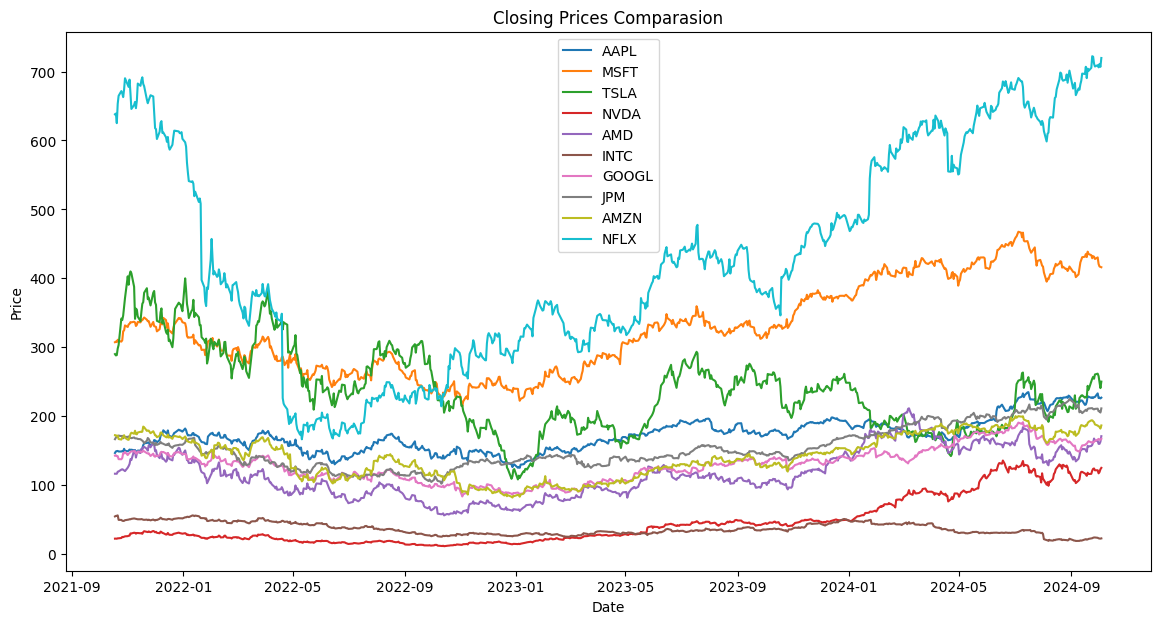

In [6]:
plt.figure(figsize=(14,7))
for stock in stocks:
    plt.plot(all_data[stock].index, all_data[stock]['Close'], label=stock)
plt.title('Closing Prices Comparasion')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
X_train_all, X_test_all, y_train_all, y_test_all = {}, {}, {}, {}

for stock in stocks:
    X = all_data[stock][['Open', 'High', 'Low', 'Volume', 'MA50', 'MA200', 'RSI', 'Upper_BB', 'Lower_BB']]
    y = all_data[stock]['Close']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_all[stock] = X_train_scaled
    X_test_all[stock] = X_test_scaled
    y_train_all[stock] = y_train
    y_test_all[stock] = y_test

In [8]:
k = 5
knn_models = {}

Mean Squared Error for AAPL: 5.6769460207227
Mean Squared Error for MSFT: 36.247929926185186
Mean Squared Error for TSLA: 52.54895467175448
Mean Squared Error for NVDA: 3.5644604780063944
Mean Squared Error for AMD: 14.231974158996836
Mean Squared Error for INTC: 0.62541080761295
Mean Squared Error for GOOGL: 4.3977011397712715
Mean Squared Error for JPM: 5.554435784216751
Mean Squared Error for AMZN: 10.24397494110999
Mean Squared Error for NFLX: 118.18072014820729


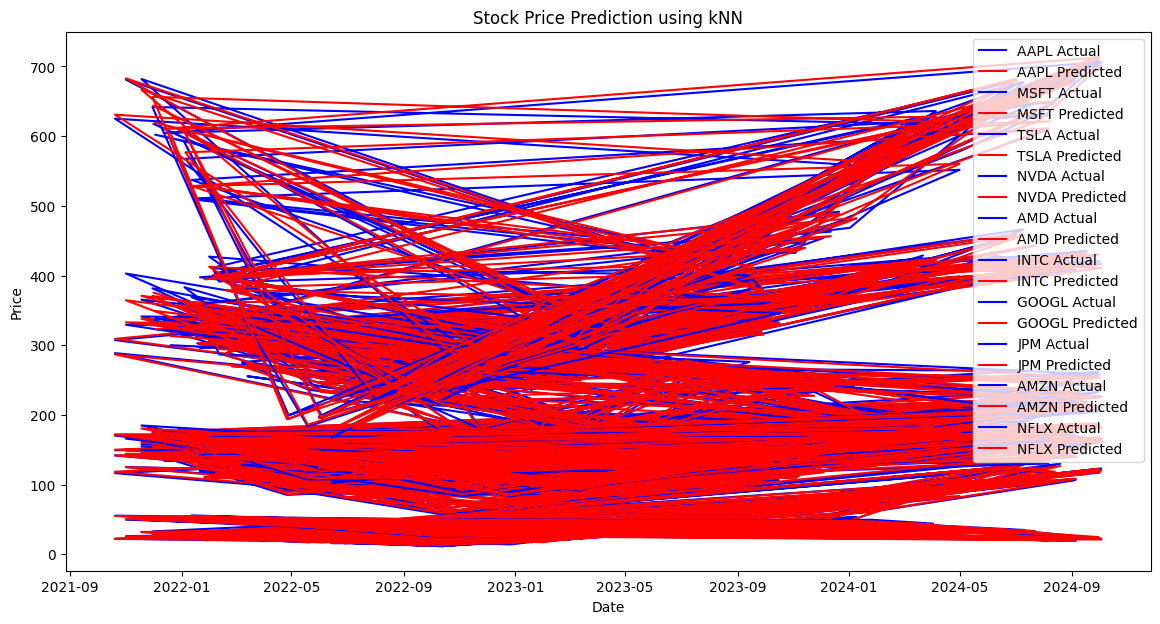

In [9]:
plt.figure(figsize=(14,7))
for stock in stocks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_all[stock], y_train_all[stock])
    knn_models[stock] = knn
    
    y_pred = knn.predict(X_test_all[stock])

    mse = mean_squared_error(y_test_all[stock], y_pred)
    print(f'Mean Squared Error for {stock}: {mse}')

    plt.plot(y_test_all[stock].index, y_test_all[stock], label=f'{stock} Actual', color='b')
    plt.plot(y_test_all[stock].index, y_pred, label=f'{stock} Predicted', color='r')

plt.title('Stock Price Prediction using kNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

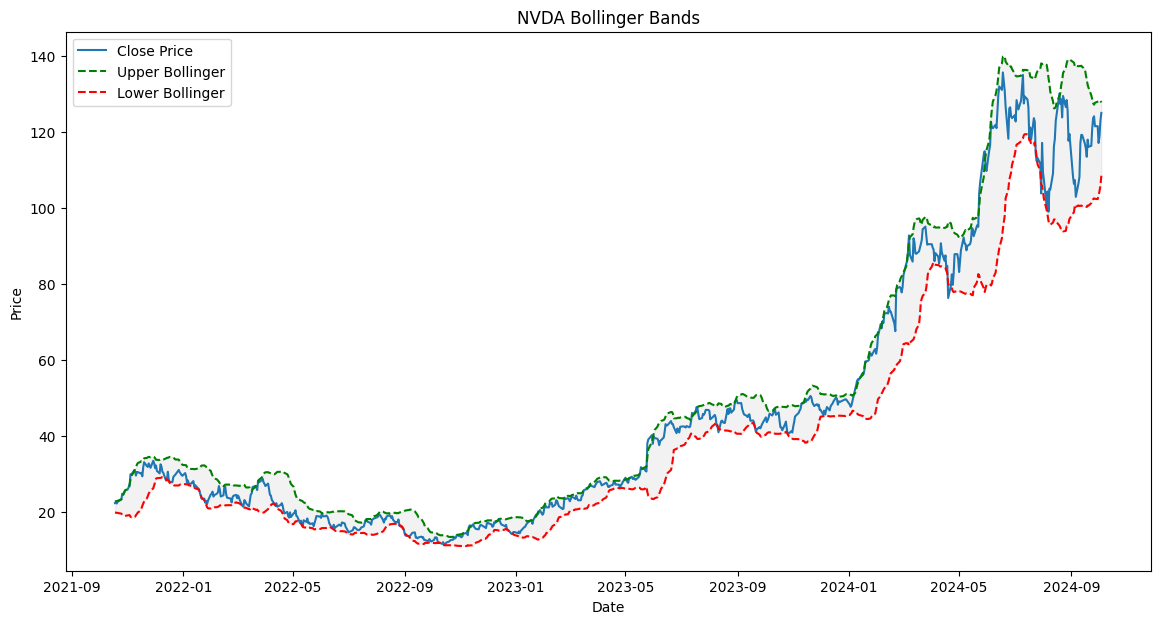

In [10]:
stock = 'NVDA'
plt.figure(figsize=(14,7))
plt.plot(all_data[stock].index, all_data[stock]['Close'], label='Close Price')
plt.plot(all_data[stock].index, all_data[stock]['Upper_BB'], label='Upper Bollinger', linestyle='--', color='green')
plt.plot(all_data[stock].index, all_data[stock]['Lower_BB'], label='Lower Bollinger', linestyle='--', color='red')
plt.fill_between(all_data[stock].index, all_data[stock]['Lower_BB'], all_data[stock]['Upper_BB'], color='grey', alpha=0.1)
plt.title(f'{stock} Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

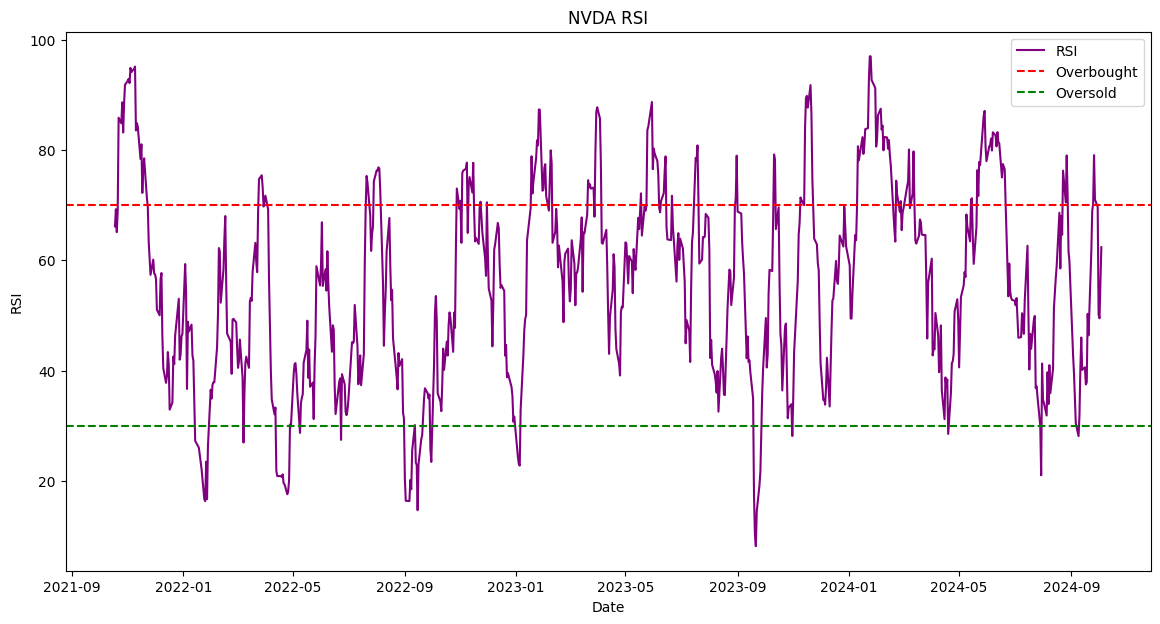

In [11]:
plt.figure(figsize=(14,7))
plt.plot(all_data[stock].index, all_data[stock]['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title(f'{stock} RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

In [13]:
for stock in stocks:
    future_price = knn_models[stock].predict([X_test_all[stock][-1]])[0]
    current_price = y_test_all[stock].iloc[-1]

    if future_price > current_price:
        recommendation = "Buy"
    elif future_price < current_price:
        recommendation = "Sell"
    else:
        recommendation = "Hold"

    print(f'{stock} Recommendation: {recommendation}')

AAPL Recommendation: Buy
MSFT Recommendation: Buy
TSLA Recommendation: Buy
NVDA Recommendation: Sell
AMD Recommendation: Buy
INTC Recommendation: Buy
GOOGL Recommendation: Buy
JPM Recommendation: Buy
AMZN Recommendation: Sell
NFLX Recommendation: Buy


In [14]:
# Mengunduh data untuk setiap saham
for saham in stocks:
    data = yf.download(saham, start='2021-01-01', end='2024-10-06')
    all_data[saham] = data

# Menyimpan data ke dalam file CSV
for saham, data in all_data.items():
    data.to_csv(f'data_{saham}.csv')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
